# AWS re:Invent Smarter Pharmacovigilance with AWS Machine Learning

Social media provides an ever-increasing supply of information and users are leaning towards platforms such as Facebook and Twitter to describe their healthcare experiences. This presents another channel and opportunity for customers in Healthcare and Life Sciences to capture, investigate and report Adverse Drug Reactions (ADR) faster and in larger quantities than traditional reporting systems.

In this session, we will train and deploy a transformer-based deep learning model, using the [Amazon SageMaker and Hugging Face](https://docs.aws.amazon.com/sagemaker/latest/dg/hugging-face.html), to classify ADRs in social media data. 

#  Link to this repository: todo-insert-github-repo-link

# Agenda

* Introductions - Speakers and Attendees:             [5 mins]
* Use case and solution overview:                     [10 mins]
    * Identifying Adverse Drug Reaction (ADR)
    * Common challenges with datasets and the ML models
* Hands-on solution development                       [30 mins]
    * Explore the Twitter ADR dataset
    * Prepare the dataset for model training
    * Fine-tuning a pre-trained BERT model using the Amazon SageMaker HuggingFace estimator
    * Deploy the trained model to a Amazon SageMaker endpoint for inference
* Discussion, Q&A:                                    [10 mins]
* Call-to-action:                                     [5 mins]


Let's get started!

# Setup

We'll begin by installing the necessary libraries, importing them into the development environment, selecting the appropriate IAM role and the Amazon S3 bucket.

## Install libraries

Select the `conda_pytorch_latest_p37` notebook kernel

Install the required libraries from Hugging Face - `transformers` and `datasets`. We'll also ensure that we have the updated version of `SageMaker Python SDK`

Documentation on [Installing Transformers](https://huggingface.co/transformers/installation.html) and [Installing SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk/tree/master)

In [1]:
!pip --quiet install "sagemaker" "transformers==4.6.1" "datasets==1.6.2" --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


## Permissions

In [2]:
import sagemaker.huggingface
import sagemaker

# The SageMaker session bucket is used to upload data, models and the corresponding logs.
# SageMaker will automatically create this bucket, if it does not exist.
sess = sagemaker.Session()
sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

#print(f"SageMaker Role Arn: {role}")
#print(f"SageMaker - Amazon S3 Bucket: {sess.default_bucket()}")
print(f"SageMaker Session Region: {sess.boto_region_name}")

SageMaker Session Region: us-east-1


# Data preparation

The dataset has been sourced from Twitter and annotated by the Diego Lab, a Biomedical Informatics Lab at Arizona State University (ASU). In the interest of research, the Diego Lab has made a subset of data publicly available.


The tweets associated with a set of drugs were collected using the generic and brand names of the drugs, and also their possible phonetic misspellings, since it is common for user posts on Twitter to contain spelling errors. Following the collection of the data, a randomly selected sample was then chosen for annotation, which consisted of 10,822 instances. This dataset is from the year 2016, after which, certain users have either edited or deleted their tweets. The data downloaded for this session contains a total of 5,594 instances. The data was annotated by two domain experts under the guidance of a pharmacology expert. Each tweet is annotated for the presence of ADRs. For more information on the data collection and annotation process, refer to the corresponding research paper - [Portable Automatic Text Classification for Adverse Drug Reaction Detection via Multi-corpus Training](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4355323/).

Also, refer to the `twitter_data_download` that contains a script to download the dataset using the Twitter API. The process to download the dataset takes a few hours.

Since, we cannot distribute the tweets as per the Twitter Privacy Policy, we create synthetic tweets that are based on the tweets annotated by the Diego Lab, a Biomedical Informatics Lab at Arizona State University (ASU). To create synthetic tweets, refer to the notebook `create_synthetic_adr_twitter_data.ipynb`.


For the rest of the session, we use the synthetic tweets in the file `adr_classify_twitter_synthetic_data.csv`

In [3]:
import pandas as pd

# Social media data is often messy and the content could have special characters.
# To ensure that we can read the CSV file appropriately through pandas, we explicitly specify the line terminator
df = pd.read_csv("adr_classify_twitter_synthetic_data.csv", lineterminator='\n')

## Exploratory data analysis

In [4]:
!pip install pandas-profiling[notebook]==3.0.0

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [5]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Twitter ADR Dataset Report")
profile

## Potential data cleaning and transformation operations

In this notebook, we haven't applied any specific data cleaning operations, since the baseline model had a strong performance.

But, social media users are creative and the data cleaning operations depend highly on your dataset. Here is a list of data cleaning and transformation operations that we recommend for your dataset

### Convert emojis to text

In [6]:
!pip --quiet install emoji

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [7]:
import emoji

In [8]:
emoji.emojize('AWS re:Invent is :thumbs_up:')

'AWS re:Invent is 👍'

In [9]:
emoji.demojize('I ❤ Python')

'I :red_heart: Python'

In [10]:
s = "Is it 630 yet?!? I'm ready for a free dinner and drinks thanks to Effient 💊💊💊"

emoji.demojize(s, delimiters=(' ', ' '))

"Is it 630 yet?!? I'm ready for a free dinner and drinks thanks to Effient  pill  pill  pill "

Similarly, you could use the `emot` library for emoticons. Reference - https://github.com/NeelShah18/emot

### Detect medical entites and remove PHI using Amazon Comprehend Medical

In [11]:
'9:26 Day 12 Rivaroxaban diary: headache, right shoulder and neck pain, lower back pain, weak knees, limp when walking.Paracetamol taken'

'9:26 Day 12 Rivaroxaban diary: headache, right shoulder and neck pain, lower back pain, weak knees, limp when walking.Paracetamol taken'

To obtain the visualization as below, navigate to `Amazon Comprehend` from the AWS Management Console; then `Launch Amazon Comprehend Medical` and navigate to the `Real-time analysis` tab.

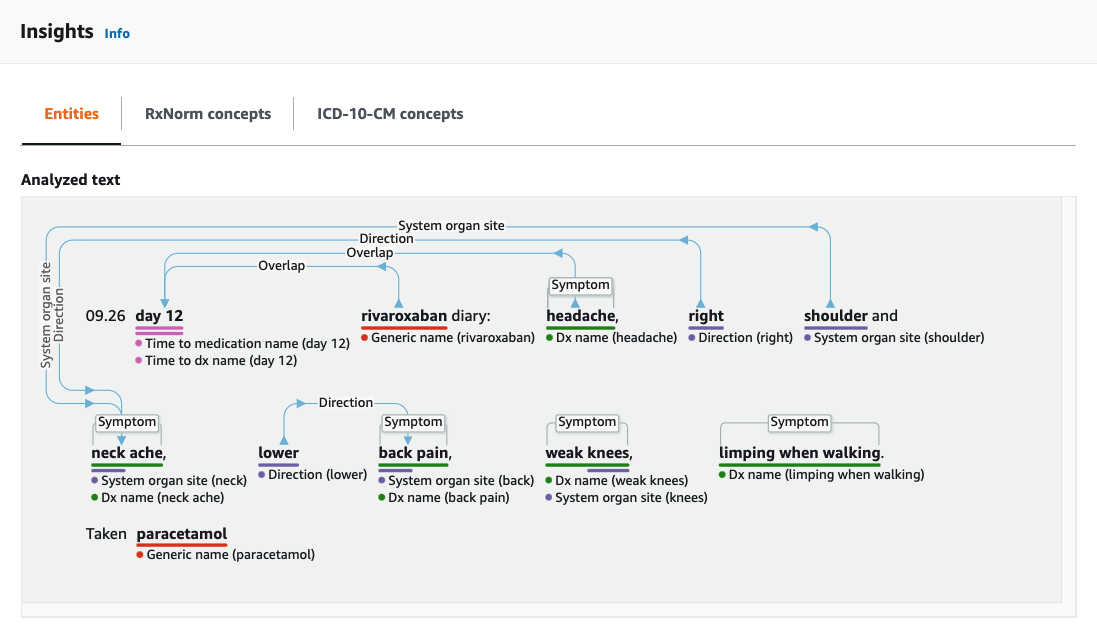

In [12]:
from IPython.display import Image
Image(filename="images/comprehend_medical_visualization.png")

To run the cell below ensure that the IAM role attached to the SageMaker notebook instance has perimissions to invoke the `comprehendmedical:DetectEntitiesV2` API. For more information on attaching the necessary policies and adding trusted entites, refer to the documentation - [Creating a role to delegate permissions to an AWS service](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles_create_for-service.html)

For a complete list of entitity types within Comprehend Medical, refer to the [documentation](https://docs.aws.amazon.com/comprehend/latest/dg/extracted-med-info-V2.html)

### Additional recommendations


1. Remove special characters, URLs, usernames.
2. Leverage libraries geared towards cleaning social media text such as - [Ekphrasis](https://github.com/cbaziotis/ekphrasis) for tokenization, word normalization, word segmentation (for splitting hashtags) and spell correction, specifically for social media text.
3. If your customer support team responds to candidate adverse event comments on social media, filter the support team's comments out to avoid any bias.
4. We may not need the entire text content to make a prediction. Often times in social networks such as Facebook, the comments could be very long. In such scenarios, comments can be cropped to, say 200 tokens, to speed up the data transformations. The maximum length of a comment can be fine-tuned to improve model performance.

![](images/arch_aws_consultant.png)

## Discussion: What other transformations would you use?

![](images/arch_aws_consultant.png)

## Prepare the dataset for modeling

Create train-validation-test stratified splits of the dataset. Stratification ensures that all classes are equally well represented across the train, validation and test datasets.

In [13]:
from sklearn.model_selection import train_test_split

target = 'label'
cols = df.columns[df.columns != target]

X = df[cols]
y = df[target]

# Data split: 5.2%(val) of the 95% (train and test) of the dataset ~ 5%; resulting in 90:5:5 split
test_dataset_size = 0.05
val_dataset_size = 0.052
RANDOM_STATE = 42


# Stratified train-val-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_dataset_size, stratify=y, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_dataset_size, stratify=y_train, random_state=RANDOM_STATE)

print('Dataset: train ', X_train.shape, y_train.shape, y_train.value_counts(dropna=False, normalize=True).to_dict())
print('Dataset: val ', X_val.shape, y_val.shape, y_val.value_counts(dropna=False, normalize=True).to_dict())
print('Dataset: test ', X_test.shape, y_test.shape, y_test.value_counts(dropna=False, normalize=True).to_dict())

# Combine the independent columns with the label
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)

Dataset: train  (4371, 1) (4371,) {0: 0.8945321436742164, 1: 0.10546785632578358}
Dataset: val  (240, 1) (240,) {0: 0.8958333333333334, 1: 0.10416666666666667}
Dataset: test  (243, 1) (243,) {0: 0.8930041152263375, 1: 0.10699588477366255}


Convert the pandas dataframes into Hugging Face datasets for downstream modeling

In [14]:
from datasets import Dataset

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# REMOVE below since tweet_id and user_id are not present
# drop the tweet_id and user_id columns, since we will not use them for modeling
# df_train = df_train[['text', 'label']]
# df_val = df_val[['text', 'label']]

dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)

In [15]:
dataset_train

Dataset({
    features: ['text', 'label'],
    num_rows: 4371
})

In [16]:
dataset_val

Dataset({
    features: ['text', 'label'],
    num_rows: 240
})

## Tokenize the text

Tokenize the `text` field in the dataset

In [17]:
from transformers import AutoTokenizer
tokenizer_and_model_name = 'roberta-large'

# Download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_and_model_name)

# Tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

dataset_train_tokenized = dataset_train.map(tokenize, batched=True, batch_size=len(dataset_train))
dataset_val_tokenized = dataset_val.map(tokenize, batched=True, batch_size=len(dataset_val))

In [18]:
dataset_train_tokenized, dataset_val_tokenized

(Dataset({
     features: ['attention_mask', 'input_ids', 'label', 'text'],
     num_rows: 4371
 }),
 Dataset({
     features: ['attention_mask', 'input_ids', 'label', 'text'],
     num_rows: 240
 }))

In [19]:
# convert array/list to PyTorch tensors
dataset_train_tokenized = dataset_train_tokenized.rename_column("label", "labels")
dataset_train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

dataset_val_tokenized = dataset_val_tokenized.rename_column("label", "labels")
dataset_val_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

## Upload tokenized dataset to Amazon S3

In [20]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()
s3_prefix = 'reinvent-builders-session/datasets/adr-twitter'

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
dataset_train_tokenized.save_to_disk(training_input_path,fs=s3)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
dataset_val_tokenized.save_to_disk(test_input_path,fs=s3)

# Model Training: Amazon SageMaker - Hugging Face

## Overview of transfer learning

![](images/bert_transfer_learning.png)

This illustration is from Alammar, J (2021). The Illustrated BERT, ELMo, and co. Retrieved from https://jalammar.github.io/illustrated-bert/

Other resources for learning more about transfer learning and BERT include - 1) [Recent Advances in Language Model Fine-tuning](https://ruder.io/recent-advances-lm-fine-tuning/) by Sebastian Ruder; 2) [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) by Jay Alammar; 3) [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805); 4) [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692) and 5) [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

## Model fine-tuning

Now that we are done with data preparation, we are ready to train our model. We start with a pre-trained model i.e RoBERTa and fine-tune the model for the specific task of identifying ADRs in the dataset. We can leverage the Hugging Face Estimator class within SageMaker to load the pre-trained model, fine-tune it, and managed the end-to-end model training process.


Ensure that the `transformers_version`, `pytorch_version` and `py_version` are aligned, as specificed in the [Deep Learning Container (DLC) documentation](https://huggingface.co/docs/sagemaker/main)

In [21]:
hyperparameters = {'epochs': 4,
                   'train_batch_size': 4,
                   'model_name': tokenizer_and_model_name}

In [22]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}
]

In [23]:
from sagemaker.huggingface import HuggingFace

huggingface_estimator = HuggingFace(
                            entry_point='train.py',
                            source_dir='./scripts',
                            base_job_name='huggingface-sdk-extension',
                            instance_type='ml.p3.16xlarge',
                            instance_count=1,
                            volume_size=100,
                            transformers_version='4.6.1',
                            pytorch_version='1.7.1',
                            py_version='py36',
                            role=role,
                            hyperparameters=hyperparameters,
                            metric_definitions=metric_definitions
                        )

Start model training by calling the fit method in the estimator. 

![](images/sagemaker_training_job.png)

## Additional recommendations


1. Real-world labels are often noisy i.e. observations that are not adverse events, could be labeled as adverse events; and vice-versa. Noisy labels can mislead the model and degrade its' performance. We have found that smaller, cleaner datasets can outperform large, noisy datasets. You could explore regularization techniques such as label smoothing to prevent the model from learning noisy labels and reduce overfitting. [When Does Label Smoothing Help?](https://arxiv.org/pdf/1906.02629.pdf)

2. Real-world datasets for identifing adverse events typically have a class imbalance i.e. only a small percentage of the entire dataset is labeled as adverse events. Methods to handle class imbalace include - applying class weights, upsampling the minority class, downsampling the majority class and augmenting the dataset with techniques such as language translation. In addition, the threshold of probability=0.5 may not be ideal in every scenario; in such cases, you can use the precision-recall curves to identify the optimal threshold.

3. [Set a random seed](https://huggingface.co/transformers/internal/trainer_utils.html?highlight=set_seed#transformers.set_seed) to ensure reproducibility during model training. The stochastic nature of many ML algorithms adds additional complexity, because the same dataset along with the same codebase could produce different outputs. This is more pronounced in deep learning algorithms, which make efficient approximations for complex computations. 

4. To select the instance size during model training, we recommend starting with an ml.p3.2xlarge instance, and increasing the instance size if there isn't sufficient memory.

5. Additional components within SageMaker such as - [SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) to organize, track, compare, and evaluate your machine learning experiments, and [SageMaker Distributed Training](https://docs.aws.amazon.com/sagemaker/latest/dg/distributed-training.html) can improve the productivity of your model training process.

![](images/arch_aws_consultant.png)

## Questions in the Model Training Phase ?

![](images/arch_aws_consultant.png)

# Model Deployment

To deploy the trained model to an endpoint, we call the `deploy()` method on the HuggingFace estimator object.

Since RoBERTa is a large pre-trained model and we are running it through multiple epochs, the training job takes an hour to complete. In the interest of time, let's load the model - with the same configuration and the same dataset, which was trained prior to the session.

Ensure that the `transformers_version`, `pytorch_version` and `py_version` are aligned, as specificed in the [Deep Learning Container (DLC) documentation](https://huggingface.co/docs/sagemaker/main)

In [ ]:
S3_PATH_TRAINED_MODEL_FILE = 's3://<INSERT-BUCKET-NAME>/<INSERT-SAGEMAKER-TRAINING-JOB-NAME>/output/model.tar.gz'

In [ ]:
from sagemaker.huggingface import HuggingFaceModel

huggingface_model = HuggingFaceModel(
    model_data=S3_PATH_TRAINED_MODEL_FILE,
    role=role,
    transformers_version='4.6.1',
    pytorch_version='1.7.1',
    py_version='py36',
)

In [ ]:
predictor = huggingface_model.deploy(initial_instance_count=1,
                                     instance_type='ml.g4dn.xlarge', 
                                     endpoint_name='reinvent-2021-pharmacovigilance-builders-session')

![](images/sagemaker_endpoint.png)

Other scenarios to deploy a model to a SageMaker endpoint include - 1) from a model stored in the [Hugging Face Hub](https://huggingface.co/models) and 2) by using a custom inference container. For more information on these methods refer to [Announcing managed inference for Hugging Face models in Amazon SageMaker](https://aws.amazon.com/blogs/machine-learning/announcing-managed-inference-for-hugging-face-models-in-amazon-sagemaker/)

# Model Inference

Once the model is deployed, we can send observations from the unseen test dataset - `df_test` to the endpoint, to make predictions.

In [27]:
df_test.head()

,text,label
0,"Prozac, Paxil, Celexa, Effexor, Remeron, Seroq...",0
1,Tysabri should be a treatment for spms when st...,0
2,"Had Paxil been available in the 13th century, ...",0
3,Oikes! I can usually fight Adderall/Vyvanse d...,0
4,Ciprofloxacin.” What's for breakfast? #Chairm...,0


Let's select a few sentences from the test dataset and send it to the endpoint for predictions.

In [32]:
sent_1 = 'So my body was goin threw withdrawl? Lol didnt kno Paxil was that strong lol'

sent_2 = 'my t cell went up with humira I also have crohns disease. I wish u guys had more articles with people like me in it'

sent_3 = 'This seroquel got me lo0o0py as helll.  This status took me at least thirty minutes to type I keep waking up without knowing I feel asleep'

tweets= {"inputs": [sent_1, sent_2, sent_3]}

predictor.predict(tweets)

[{'label': 'LABEL_1', 'score': 0.8438701629638672},
 {'label': 'LABEL_1', 'score': 0.8112441897392273},
 {'label': 'LABEL_1', 'score': 0.8174582123756409}]

In [30]:
df_test['pred'] = df_test['text'].apply(lambda ele: predictor.predict({"inputs": ele})[0]['label'])

In [31]:
df_test.head()

,text,label,pred
0,"Prozac, Paxil, Celexa, Effexor, Remeron, Seroq...",0,LABEL_0
1,Tysabri should be a treatment for spms when st...,0,LABEL_0
2,"Had Paxil been available in the 13th century, ...",0,LABEL_0
3,Oikes! I can usually fight Adderall/Vyvanse d...,0,LABEL_0
4,Ciprofloxacin.” What's for breakfast? #Chairm...,0,LABEL_0


# Cleanup

When we are done with the endpoint, we can delete it to save cost.

In [33]:
predictor.delete_endpoint()

# Resources

1. [Use Hugging Face with Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/hugging-face.html)
2. [Hugging Face sample notebooks](https://github.com/huggingface/notebooks/tree/master/sagemaker)
3. [AWS Blog - AWS and Hugging Face collaborate to simplify and accelerate adoption of Natural Language Processing models](https://aws.amazon.com/blogs/machine-learning/aws-and-hugging-face-collaborate-to-simplify-and-accelerate-adoption-of-natural-language-processing-models/)
4. [AWS Blog - Announcing managed inference for Hugging Face models in Amazon SageMaker](https://aws.amazon.com/blogs/machine-learning/announcing-managed-inference-for-hugging-face-models-in-amazon-sagemaker/)
5. [The Partnership: Amazon SageMaker and Hugging Face](https://huggingface.co/blog/the-partnership-amazon-sagemaker-and-hugging-face)
6. Sarker A, Gonzalez G. Portable automatic text classification for adverse drug reaction detection via multi-corpus training. J Biomed Inform. 2015;53:196-207. doi:10.1016/j.jbi.2014.11.002

